# Comparing our algortihm against the primal dual algortihm by Jing et al. (2022) - Difference of energy at the end of the algortihm

In this notebook, we compare our proximal algorithm and the algorithm by Jing et al. (2022) by comparing the energy value at the end of the iteration. In particular, we plot the difference $(\textrm{our energy}) - (\textrm{Jing et al. energy})$. If this is positive, then ours is larger, and if this is negative, then theirs is larger.

Jing, Y., Chen, J., Li, L., & Lu, J. (2022). A deep learning framework for geodesics under spherical Wasserstein-Fisher-Rao metric and its application for weighted sample generation. arXiv. https://arxiv.org/abs/2208.12145

In [12]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
import matlab.engine
import io

# Set up

Here, we will create the densities we will use for the transport. We consider the spatial domain $[0,1]$ and the densities are chosen as follows:

$\rho_0(x) =  a N(x|b, 1/10) + (1-a)N(x, c, 1/10)$


$\rho_0(x) =  d N(x|e, 1/10) + (1-d)N(x, f, 1/10)$

where $N(x|\mu, \sigma^2)$ denotes the pdf of normal distribtuion of mean $\mu$ and variance $\sigma^2$ and $a,b,c,d,e, f$ are taken from the uniform distribution on $[0,1]$.


In [27]:
def generate_distribution(Nx):
    """ Generate initial and the terminal distribution according to the formula above.

    Args:
        Nx: Number of points in the grid.
    
    Returns:
        mu0: The initial distribution.
        mu1: The terminal distribution.
    """

    a, b, c, d, e, f = np.random.uniform(0, 1, 6)
    x = np.linspace(0, 1, Nx)
    dx = 1/Nx
    mu_0 = a * sp.stats.norm.pdf(x, b, 1/10) + (1-a)* sp.stats.norm.pdf(x, c, 1/10)
    mu_1 = d * sp.stats.norm.pdf(x, e, 1/10) + (1-d)* sp.stats.norm.pdf(x, f, 1/10)
    mu_0 /= np.sum(mu_0) * dx
    mu_1 /= np.sum(mu_1) * dx
    return mu_0, mu_1

# Calculation

✨ Starting MATLAB Engine... 🛠️
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal 

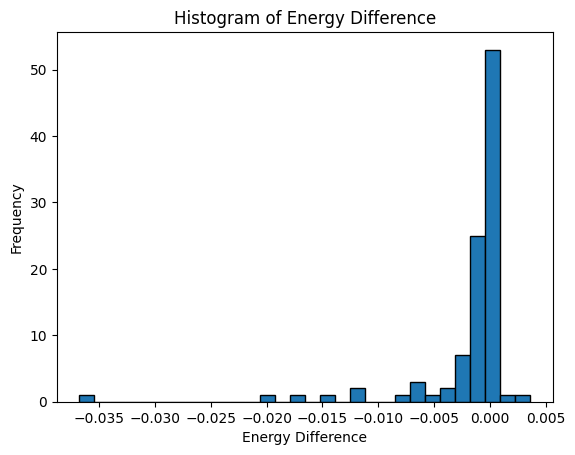

In [28]:
# Parameters
Nx = 60 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.007 # Originally 0.007
tao = 0.007 # Originally 0.007
N_itr = 10000  # Originally 1000000

X = [0, 1]
T = [0, 1]
dx = (X[1] - X[0]) / Nx
dt = 1 / Nt
x_space = np.linspace(X[0], X[1], Nx)
t_space = np.linspace(T[0], T[1], Nt)

# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

energy_diff = []

nan_count = 0
for _ in range(100):
    rho_0, rho_1 = generate_distribution(Nx)
    # our algorithm
    ll = (1.0, X[1]-X[0])
    x_ours, lists = computeGeodesic(rho_0, rho_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)
    # Jing et al. (2022)
    eng.workspace['Nx'] = float(Nx)
    eng.workspace['Nt'] = float(Nt)
    eng.workspace['alpha'] = float(alpha)
    eng.workspace['mu'] = mu
    eng.workspace['tao'] = tao
    eng.workspace['N_itr'] = N_itr
    eng.workspace['X'] = X
    eng.workspace['T'] = T
    eng.workspace['dx'] = dx
    eng.workspace['dt'] = dt
    eng.workspace['x_space'] = matlab.double(x_space.tolist())
    eng.workspace['t_space'] = matlab.double(t_space.tolist())
    eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
    eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    D = eng.workspace['D']
    if D == D:
        energy_diff.append(x_ours.V.energy(delta=1.0, p=2.0, q=2.0) - D*dx*dt)
    else:
        print('Jing et al. (2022) failed to converge.')
        nan_count += 1

# Calculate mean and variance
mean_energy_diff = np.mean(energy_diff)
variance_energy_diff = np.var(energy_diff)

# Print mean and variance
print(f"Mean of energy difference: {mean_energy_diff}")
print(f"Variance of energy difference: {variance_energy_diff}")
print(f"Number of NaNs: {nan_count}")

# Plot histogram
plt.hist(energy_diff, bins=30, edgecolor='black')
plt.title('Histogram of Energy Difference')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()

We observe that ours is constantly lower since all values are negative.

# The case where ours does not work well
In [the experiment where we compared our algorithm to Jing et al. in the SHK case](../total_mass/[PARTIAL]SHK_ours_vs_jing_gaussian.ipynb), it has been observed that our algorithm shows spikes in the solution when the domain is large. We will do the experiment in this case.

In [29]:
def generate_distribution_new(Nx, X):
    """ Generate initial and the terminal distribution according to the formula above.

    Args:
        Nx: Number of points in the grid.
    
    Returns:
        mu0: The initial distribution.
        mu1: The terminal distribution.
    """

    a, d = np.random.uniform(0, 1, 2)
    b, c, e, f = np.random.uniform(X[0], X[1], 4)
    x = np.linspace(X[0], X[1], Nx)
    dx = (X[1]-X[0])/Nx
    mu_0 = a * sp.stats.norm.pdf(x, b, 1) + (1-a)* sp.stats.norm.pdf(x, c, 1)
    mu_1 = d * sp.stats.norm.pdf(x, e, 1) + (1-d)* sp.stats.norm.pdf(x, f, 1)
    mu_0 /= np.sum(mu_0) * dx
    mu_1 /= np.sum(mu_1) * dx
    return mu_0, mu_1

# Calculation

✨ Starting MATLAB Engine... 🛠️
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal 

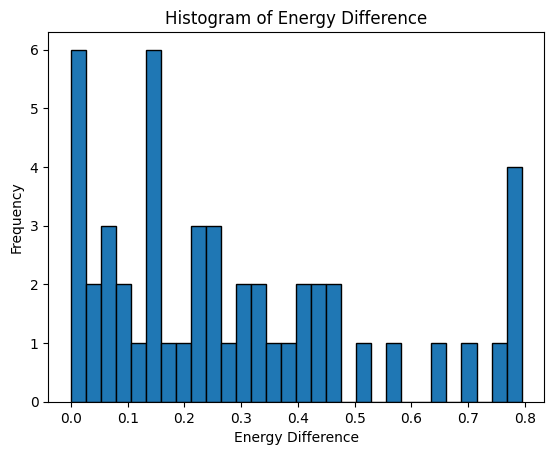

In [30]:
# Parameters
Nx = 60 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.007 # Originally 0.007
tao = 0.007 # Originally 0.007
N_itr = 10000  # Originally 1000000

X = [-7, 7]
T = [0, 1]
dx = (X[1] - X[0]) / Nx
dt = 1 / Nt
x_space = np.linspace(X[0], X[1], Nx)
t_space = np.linspace(T[0], T[1], Nt)

# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

energy_diff = []

nan_count = 0
for _ in range(100):
    rho_0, rho_1 = generate_distribution_new(Nx, X)
    # our algorithm
    ll = (1.0, X[1] - X[0])
    x_ours, lists = computeGeodesic(rho_0, rho_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)
    # Jing et al. (2022)
    eng.workspace['Nx'] = float(Nx)
    eng.workspace['Nt'] = float(Nt)
    eng.workspace['alpha'] = float(alpha)
    eng.workspace['mu'] = mu
    eng.workspace['tao'] = tao
    eng.workspace['N_itr'] = N_itr
    eng.workspace['X'] = X
    eng.workspace['T'] = T
    eng.workspace['dx'] = dx
    eng.workspace['dt'] = dt
    eng.workspace['x_space'] = matlab.double(x_space.tolist())
    eng.workspace['t_space'] = matlab.double(t_space.tolist())
    eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
    eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    D = eng.workspace['D']
    if D == D:
        energy_diff.append(x_ours.V.energy(delta=1.0, p=2.0, q=2.0) - D*dx*dt)
    else:
        print('Jing et al. (2022) failed to converge.')
        nan_count += 1

# Calculate mean and variance
mean_energy_diff = np.mean(energy_diff)
variance_energy_diff = np.var(energy_diff)

# Print mean and variance
print(f"Mean of energy difference: {mean_energy_diff}")
print(f"Variance of energy difference: {variance_energy_diff}")
print(f"Number of NaNs: {nan_count}")

# Plot histogram
plt.hist(energy_diff, bins=30, edgecolor='black')
plt.title('Histogram of Energy Difference')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()

# Observing how the scaling theorem plays in the experiment
In the original paper of the WFR, the *change of scale* formla was proven. The theorem says that, for the scaling map $T(t,x) = (t, sx)$ where $s>0$, if $(\rho, \omega, \zeta)$ is a minimizing triplet in the formula defining $\textrm{WFR}_{\delta}(\rho_0, \rho_1)$, then $(T_*\rho, sT_* \omega, sT_* \zeta)$ is a minimizing triplet in the formula defining $\textrm{WFR}_{s \delta}(T_*\rho_0, T_*\rho_1)$ and $\textrm{WFR}_{s \delta}(T_*\rho_0, T_*\rho_1)=s\textrm{WFR}_{\delta}(\rho_0, \rho_1)$. That is, the WFR problem is self-similar in the sense that the behavior of the solution does not change depending on the scale.

We will show that, when the scaling is done appropriately, the energy difference plot remains the same, verifying the scaling property.

**Reference.** Chizat, L., Schmitzer, B., Peyré, G., & Vialard, F.-X. (2015). An interpolating distance between optimal transport and Fisher-Rao. arXiv. https://arxiv.org/abs/1506.06430

# Our strategy
In this experiment, for many pairs $(\rho_0,\rho_1)$, we calculate $\textrm{WFR}_{\delta}(\rho_0, \rho_1)$ as well as $\textrm{WFR}_{s \delta}(T_*\rho_0, T_*\rho_1)$ in both algorithms. If the scaling property works for both algorithms, they should look the same up to the scaling.

In [55]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
def generate_distribution_new(Nx, X, sigma):
    """ Generate initial and the terminal distribution according to the formula above.

    Args:
        Nx: Number of points in the grid.
        X: The spatial domain.
        s: The scaling factor.
    
    Returns:
        mu0: The initial distribution.
        mu1: The terminal distribution.
    """

    a, d = np.random.uniform(0, 1, 2)
    b, c, e, f = np.random.uniform(X[0], X[1], 4)
    x = np.linspace(X[0], X[1], Nx)
    dx = (X[1]-X[0])/Nx
    mu_0 = a * sp.stats.norm.pdf(x, b, sigma) + (1-a)* sp.stats.norm.pdf(x, c, sigma)
    mu_1 = d * sp.stats.norm.pdf(x, e, sigma) + (1-d)* sp.stats.norm.pdf(x, f, sigma)
    mu_0 /= np.sum(mu_0) * dx
    mu_1 /= np.sum(mu_1) * dx
    return mu_0, mu_1

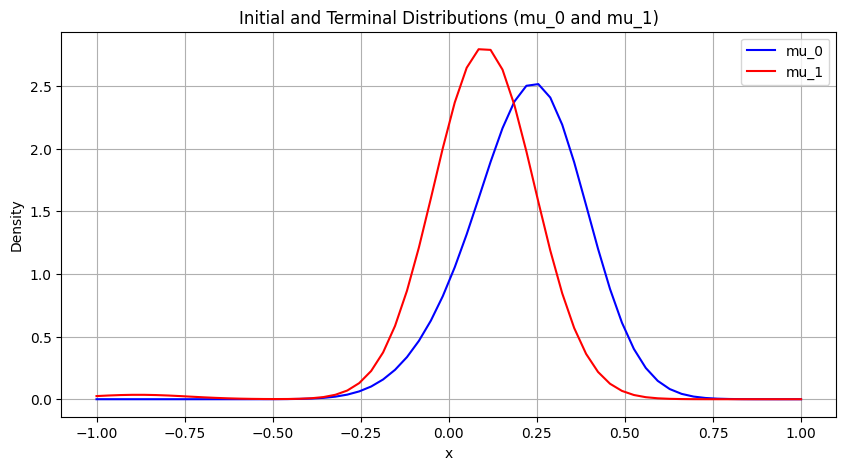

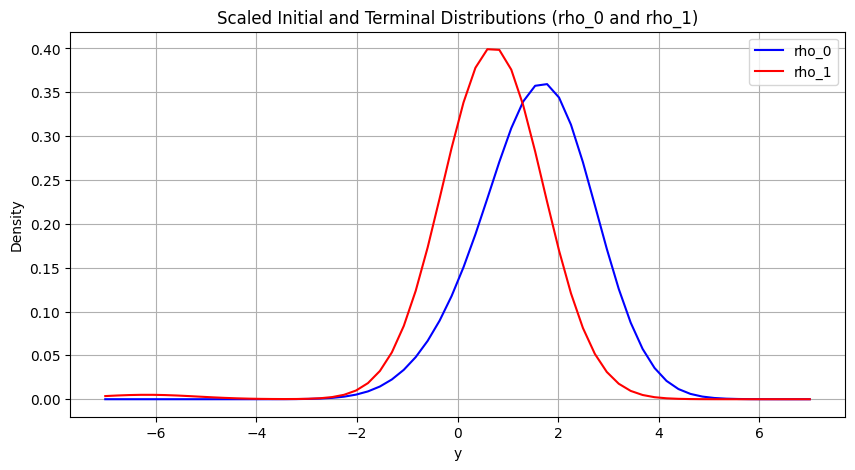

In [56]:
s = 7

Nx = 60
Nt = 15

# Domain before scaling
X = [-1, 1]
x_space = np.linspace(X[0], X[1], Nx)
mu_0, mu_1 = generate_distribution_new(Nx, X, 1/s)

# Domain after scaling
Y = [-s, s]
y_space = s * x_space
rho_0, rho_1 = (1.0/s) * mu_0, (1.0/s) * mu_1

# Plot mu_0 and mu_1
plt.figure(figsize=(10, 5))
plt.plot(x_space, mu_0, label='mu_0', color='blue')
plt.plot(x_space, mu_1, label='mu_1', color='red')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Initial and Terminal Distributions (mu_0 and mu_1)')
plt.legend()
plt.grid()
plt.show()

# Plot rho_0 and rho_1
plt.figure(figsize=(10, 5))
plt.plot(y_space, rho_0, label='rho_0', color='blue')
plt.plot(y_space, rho_1, label='rho_1', color='red')
plt.xlabel('y')
plt.ylabel('Density')
plt.title('Scaled Initial and Terminal Distributions (rho_0 and rho_1)')
plt.legend()
plt.grid()
plt.show()


# Calculation

✨ Starting MATLAB Engine... 🛠️
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Mean of energy difference before scaling: -0.01465718173579561
Variance of energy difference before scaling: 0.00030401494813815037
Number of NaNs: 0
Mean of energy difference after scaling

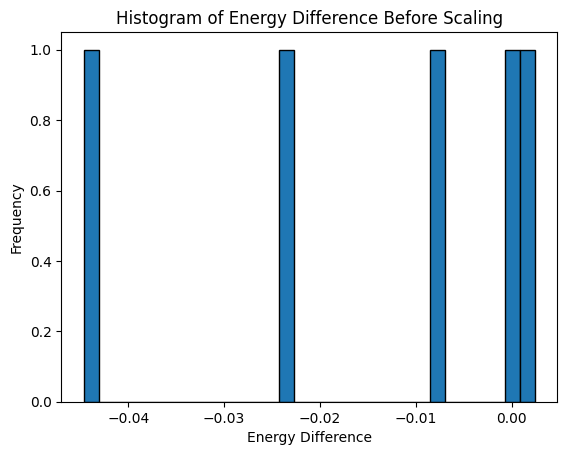

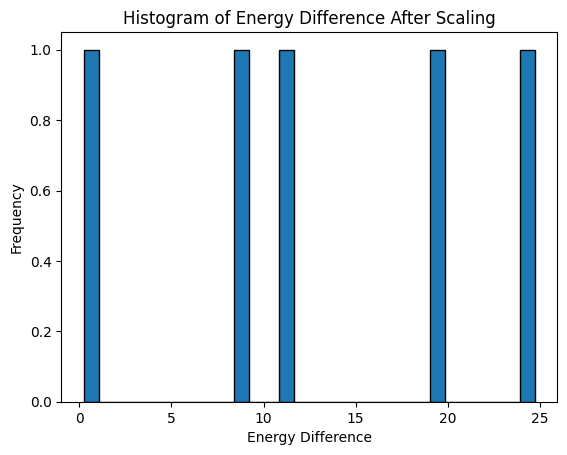

In [28]:
# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.007 # Originally 0.007
tao = 0.007 # Originally 0.007
N_itr = 10000  # Originally 1000000

T = [0, 1]
dx = (X[1] - X[0]) / Nx
dt = 1 / Nt
t_space = np.linspace(T[0], T[1], Nt)

# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

energy_diffx = []
energy_diffy = []

nan_count = 0
for _ in range(5):
    mu_0, mu_1 = generate_distribution_new(Nx, X, 1/s)
    rho_0, rho_1 = (1.0/s) * mu_0, (1.0/s) * mu_1
    # our algorithm
    llx = (1.0, X[1]-X[0])
    lly = (1.0, Y[1]-Y[0])
    x_ours, xlists = computeGeodesic(mu_0, mu_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)
    y_ours, ylists = computeGeodesic(rho_0, rho_1, Nt, lly, p= 2.0, q=2.0, delta=s*delta, niter=N_itr)
    
    # Jing et al. (2022)
    eng.workspace['Nx'] = float(Nx)
    eng.workspace['Nt'] = float(Nt)
    eng.workspace['alpha'] = float(alpha)
    eng.workspace['mu'] = mu
    eng.workspace['tao'] = tao
    eng.workspace['N_itr'] = N_itr
    eng.workspace['X'] = X
    eng.workspace['T'] = T
    eng.workspace['dx'] = dx
    eng.workspace['dt'] = dt
    eng.workspace['x_space'] = matlab.double(x_space.tolist())
    eng.workspace['t_space'] = matlab.double(t_space.tolist())
    eng.workspace['rho_0'] = matlab.double(mu_0.tolist())
    eng.workspace['rho_1'] = matlab.double(mu_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    Dx = eng.workspace['D']
    if Dx == Dx:
        energy_diffx.append(x_ours.V.energy(delta=1.0, p=2.0, q=2.0) - Dx*dx*dt)
    else:
        print('Jing et al. (2022) failed to converge.')
        nan_count += 1
    
    eng.workspace['alpha'] = s**2 * float(alpha)
    eng.workspace['X'] = Y
    eng.workspace['dx'] = s * dx
    eng.workspace['x_space'] = matlab.double(y_space.tolist())
    eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
    eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    Dy = eng.workspace['D']
    if Dy == Dy:
        energy_diffy.append(y_ours.V.energy(delta=s*1.0, p=2.0, q=2.0) - Dy*s*dx*dt)
    else:
        print('Jing et al. (2022) failed to converge.')

# Calculate mean and variance
mean_energy_diffx = np.mean(energy_diffx)
variance_energy_diffx = np.var(energy_diffx)
mean_energy_diffy = np.mean(energy_diffy)
variance_energy_diffy = np.var(energy_diffy)

# Print mean and variance
print(f"Mean of energy difference before scaling: {mean_energy_diffx}")
print(f"Variance of energy difference before scaling: {variance_energy_diffx}")
print(f"Number of NaNs: {nan_count}")
print(f"Mean of energy difference after scaling: {mean_energy_diffy}")
print(f"Variance of energy difference after scaling: {variance_energy_diffy}")

# Plot histogram
plt.hist(energy_diffx, bins=30, edgecolor='black')
plt.title('Histogram of Energy Difference Before Scaling')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()

plt.hist(energy_diffy, bins=30, edgecolor='black')
plt.title('Histogram of Energy Difference After Scaling')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()

We observe that the scaling property fails. To see which algorithm is at fault, we look at the numerical value of the energy for the last example.

In [54]:
print('s ** 2 times the energy before scaling for ours:', s**2 * x_ours.V.energy(delta=1.0, p=2.0, q=2.0))
print('Energy after scaling for ours:', y_ours.V.energy(delta=s*1.0, p=2.0, q=2.0))
print('s ** 2 times the energy before scaling for Jing et al. (2022):', s ** 2 * Dx*dx*dt)
print('Energy after scaling for Jing et al. (2022):', Dy*s*dx*dt)

s ** 2 times the energy before scaling for ours: 0.6288948561445007
Energy after scaling for ours: 0.6288948561445007
s ** 2 times the energy before scaling for Jing et al. (2022): 0.643576212436151
Energy after scaling for Jing et al. (2022): 0.4650397990196576


The numerical values show that the scaling property is failing for their algorithm. To verify this is true for large number of examples, we plot $\textrm{(energy after scaling)}-s^2\textrm{(energy before scaling)}$ for many examples. If the scaling property is true, then it should be close to zero.

In [ ]:
# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.007 # Originally 0.007
tao = 0.007 # Originally 0.007
N_itr = 10000  # Originally 1000000

T = [0, 1]
dx = (X[1] - X[0]) / Nx
dt = 1 / Nt
t_space = np.linspace(T[0], T[1], Nt)

# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

scaling_margin_ours = []
scaling_margin_jing = []

nan_count = 0
for _ in range(100):
    mu_0, mu_1 = generate_distribution_new(Nx, X, 1/s)
    rho_0, rho_1 = (1.0/s) * mu_0, (1.0/s) * mu_1
    # our algorithm
    llx = (1.0, X[1]-X[0])
    lly = (1.0, Y[1]-Y[0])
    x_ours, xlists = computeGeodesic(mu_0, mu_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)
    y_ours, ylists = computeGeodesic(rho_0, rho_1, Nt, lly, p= 2.0, q=2.0, delta=s*delta, niter=N_itr)
    scaling_margin_ours.append(y_ours.V.energy(delta=s*1.0, p=2.0, q=2.0) - (s ** 2) * x_ours.V.energy(delta=1.0, p=2.0, q=2.0))
    
    # Jing et al. (2022)
    eng.workspace['Nx'] = float(Nx)
    eng.workspace['Nt'] = float(Nt)
    eng.workspace['alpha'] = float(alpha)
    eng.workspace['mu'] = mu
    eng.workspace['tao'] = tao
    eng.workspace['N_itr'] = N_itr
    eng.workspace['X'] = X
    eng.workspace['T'] = T
    eng.workspace['dx'] = dx
    eng.workspace['dt'] = dt
    eng.workspace['x_space'] = matlab.double(x_space.tolist())
    eng.workspace['t_space'] = matlab.double(t_space.tolist())
    eng.workspace['rho_0'] = matlab.double(mu_0.tolist())
    eng.workspace['rho_1'] = matlab.double(mu_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    Dx = eng.workspace['D']
    
    eng.workspace['alpha'] = s**2 * float(alpha)
    eng.workspace['X'] = Y
    eng.workspace['dx'] = s * dx
    eng.workspace['x_space'] = matlab.double(y_space.tolist())
    eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
    eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    Dy = eng.workspace['D']
    scaling_margin_jing.append(Dy * s * dx * dt - s ** 2 * Dx * dx * dt)

# Calculate mean and variance
mean_scaling_margin_ours = np.mean(scaling_margin_ours)
variance_scaling_margin_ours = np.var(scaling_margin_ours)
mean_scaling_margin_jing = np.mean(scaling_margin_jing)
variance_scaling_margin_jing = np.var(scaling_margin_jing)

# Print mean and variance
print(f"Mean of scaling margin for ours: {mean_scaling_margin_ours}")
print(f"Variance of scaling margin for ours: {variance_scaling_margin_ours}")
print(f"Mean of scaling margin for Jing et al. (2022): {mean_scaling_margin_jing}")
print(f"Variance of scaling margin for Jing et al. (2022): {variance_scaling_margin_jing}")

# Plot histogram
plt.hist(scaling_margin_ours, bins=30, edgecolor='black')
plt.title('Histogram of Scaling Margin for Ours')
plt.xlabel('Scaling Margin')
plt.ylabel('Frequency')
plt.show()

plt.hist(scaling_margin_jing, bins=30, edgecolor='black')
plt.title('Histogram of Scaling Margin for Jing et al. (2022)')
plt.xlabel('Scaling Margin')
plt.ylabel('Frequency')
plt.show()

✨ Starting MATLAB Engine... 🛠️
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal 

We observe that while our algortihm works well in terms of scalling, theirs seems to be struggling.